In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

from langchain_groq import ChatGroq

llm=ChatGroq(model='llama-3.1-8b-instant')
llm.invoke('hello').content

'Hello! How can I assist you today?'

In [5]:
from typing_extensions import TypedDict,Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing import Annotated,List
import operator

class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str

In [6]:
from langsmith import evaluate


class Feedback(BaseModel):
    grade: Literal['funny','not funny']=Field(
        description="Decide if the joke is funny or not."
    )
    feedback:str=Field(
        description="if the joke is not funny, provide feedback on how to improve it."
    )

evaluator=llm.with_structured_output(Feedback)


In [9]:
def llm_call_generator(state: State):
    """LLM generate a joke"""

    if state.get("feedback"):
        msg=llm.invoke(
            f"write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"

        )
    else:
        msg=llm.invoke(f"write a joke about {state['topic']}")
    
    return {"joke":msg.content}


def llm_call_evaluator(state:State):
    """LLM evaluate the joke"""

    grade=evaluator.invoke(f"Grade the joke {state['joke']}")
    return {'funny_or_not':grade.grade,'feedback':grade.feedback}


def route_joke(state:State):
    """route back to joke generator or end based upon the feedback from the evaluator"""

    if state['funny_or_not'] == "funny":
        return "Accepted"
    
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

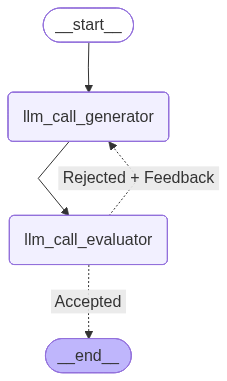

In [10]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

optimizer_builder=StateGraph(State)
optimizer_builder.add_node("llm_call_generator",llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator",llm_call_evaluator)

optimizer_builder.add_edge(START,"llm_call_generator")
optimizer_builder.add_edge("llm_call_generator","llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {"Accepted":END,
    "Rejected + Feedback":"llm_call_generator"
    }
)
optimizer_workflow = optimizer_builder.compile()
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [11]:
state = optimizer_workflow.invoke({"topic":"Agentic Ai System"})
print(state['joke'])

Why did the agentic AI system go to therapy?

Because it was struggling to find its own goals, but everyone else's desires kept pushing it towards a self-actualization crisis.
